In [4]:
import itertools
import os
import geopandas as gpd
#import geodatasets
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from shapely.geometry import shape
import utm
import folium
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import spectral
from spectral import envi
import rasterio
from rasterio import features as feats 
from rasterio.transform import from_origin

In [5]:
import importlib
import ninjaGEO
num=100

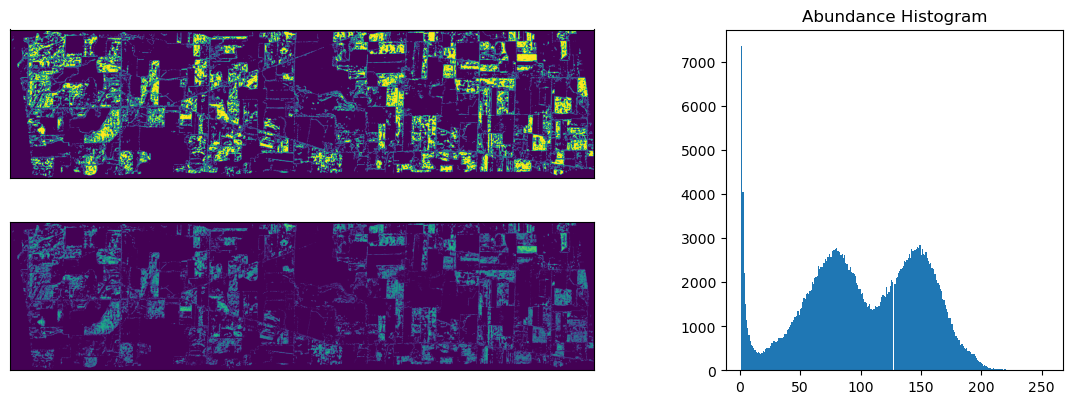

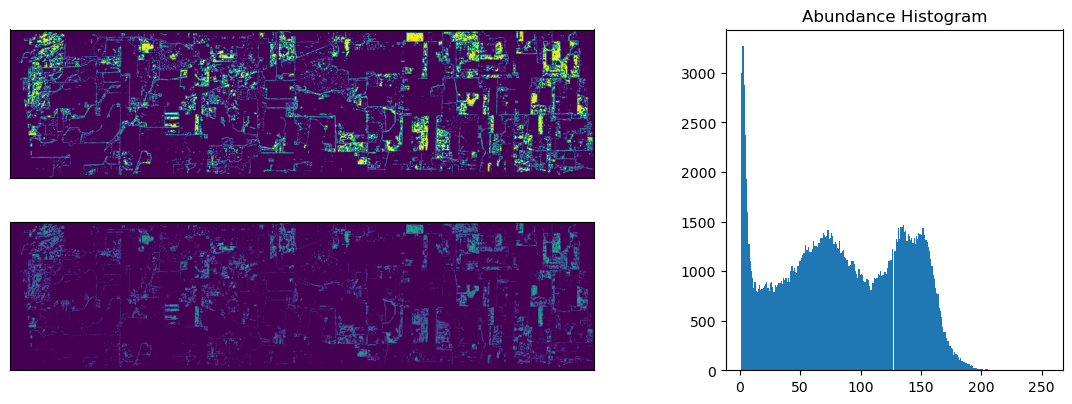

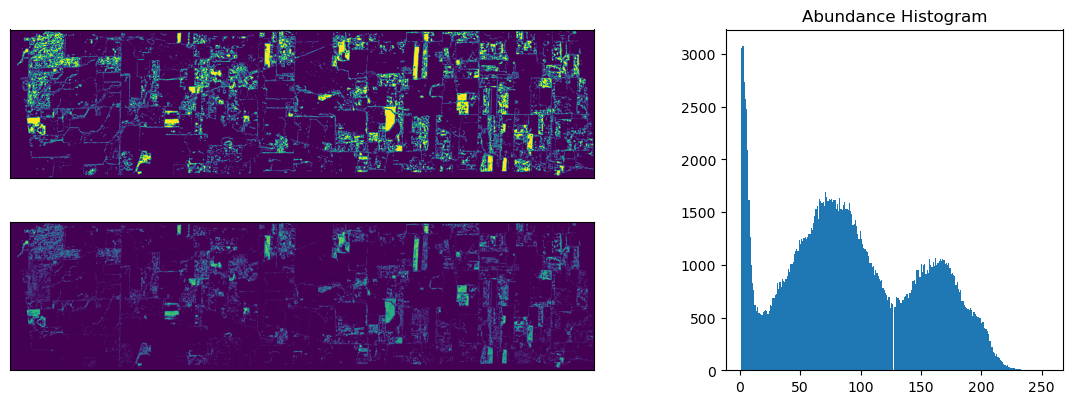

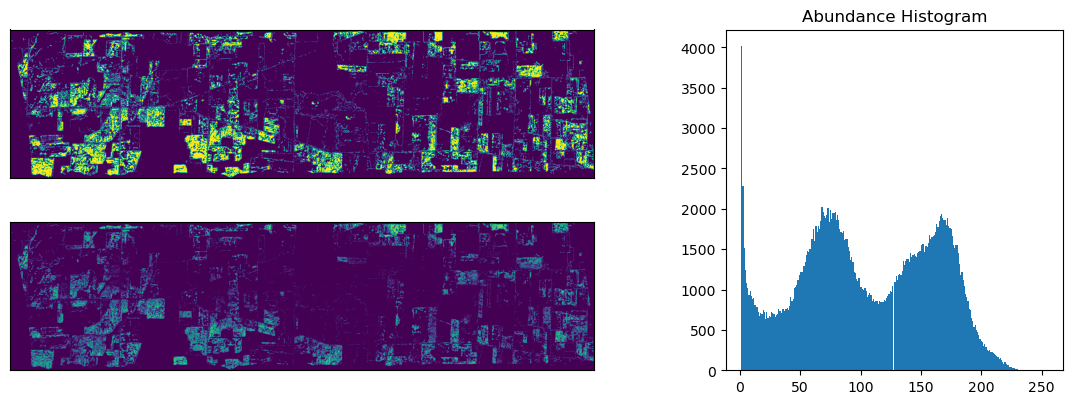

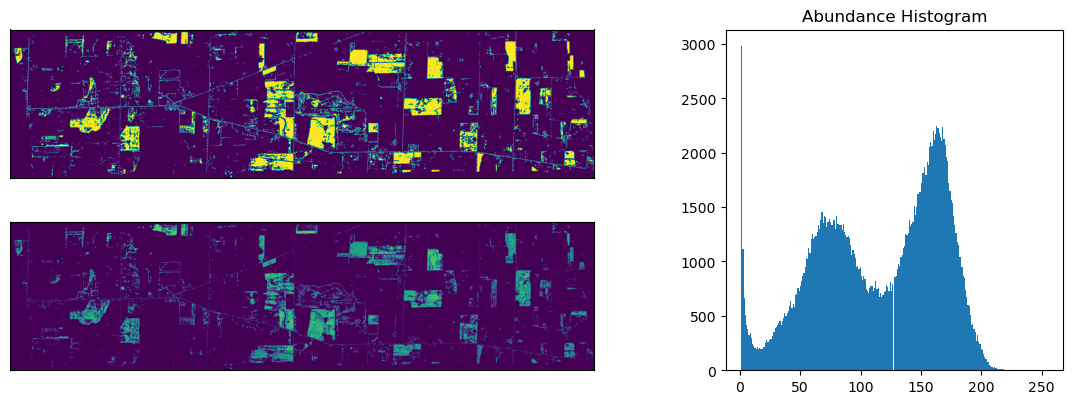

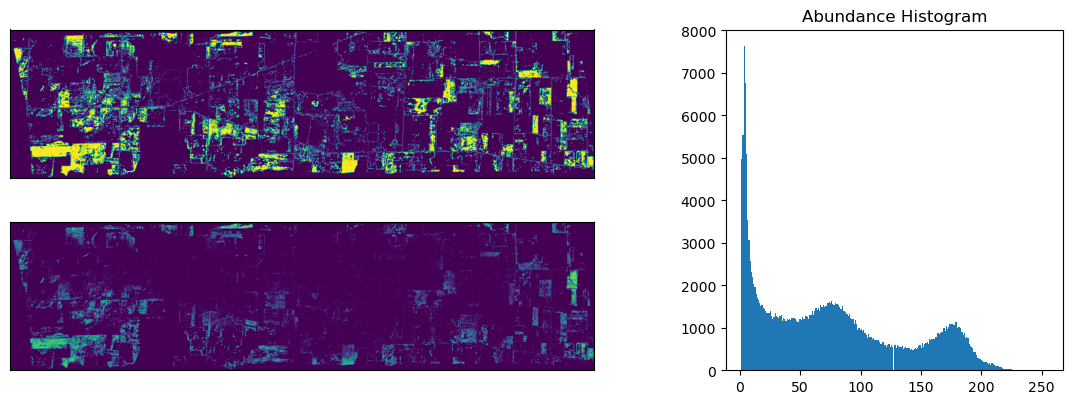

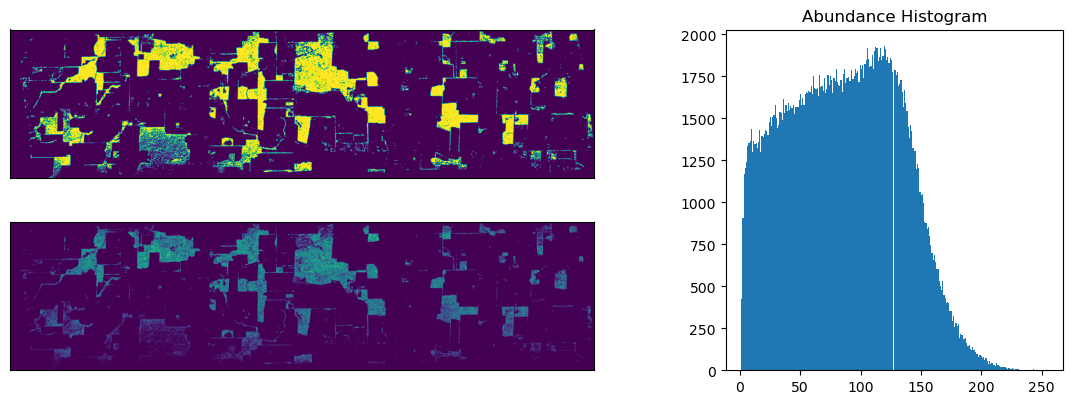

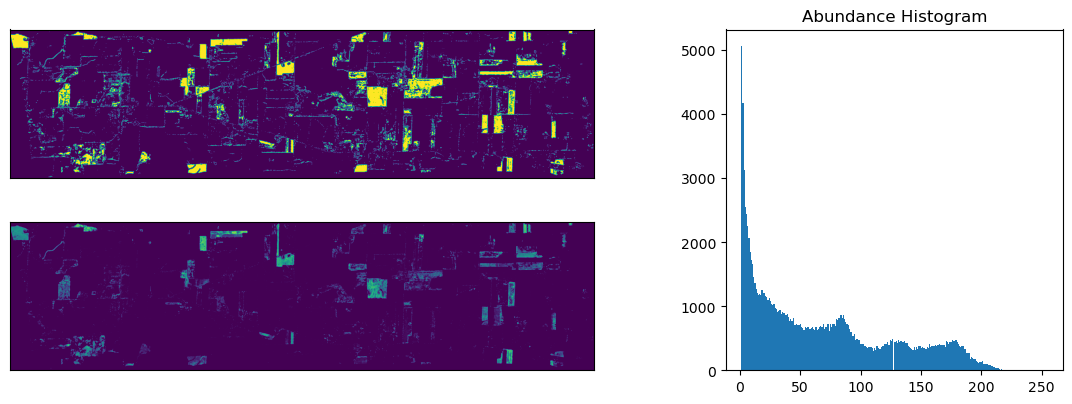

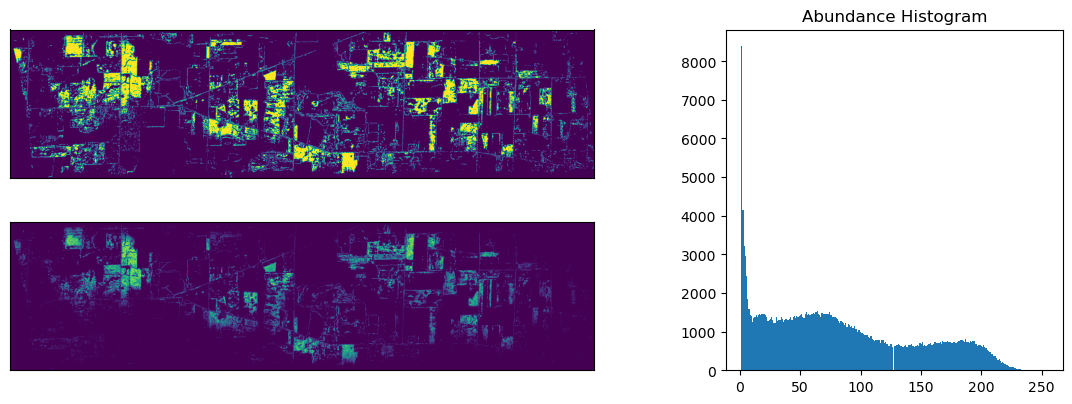

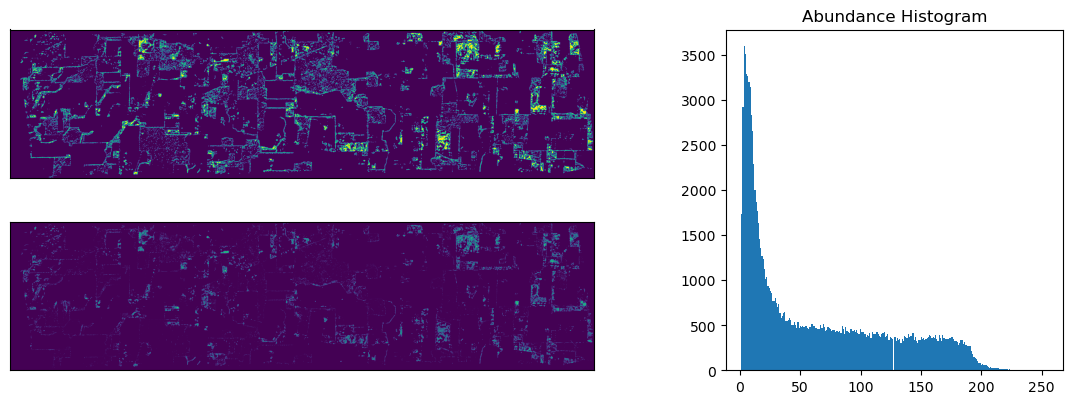

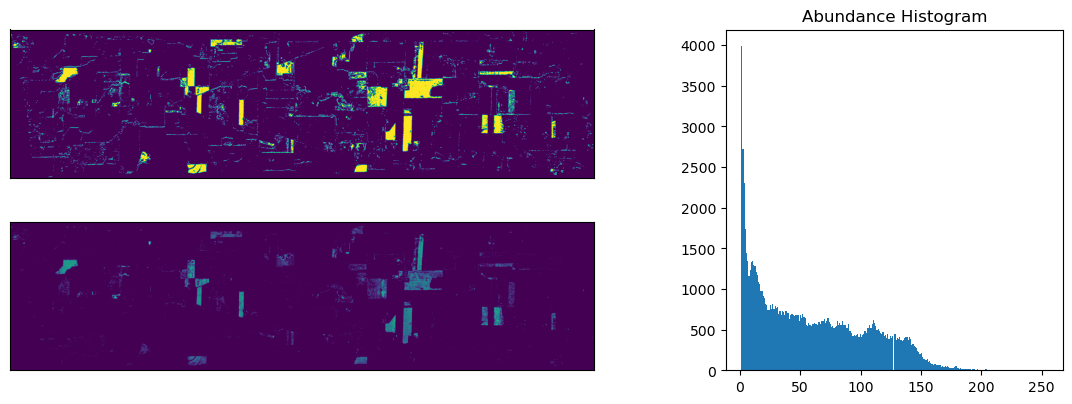

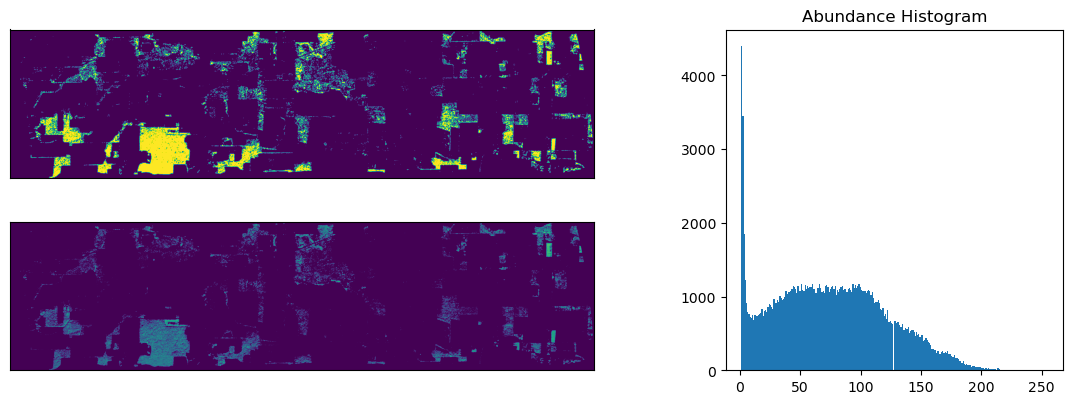

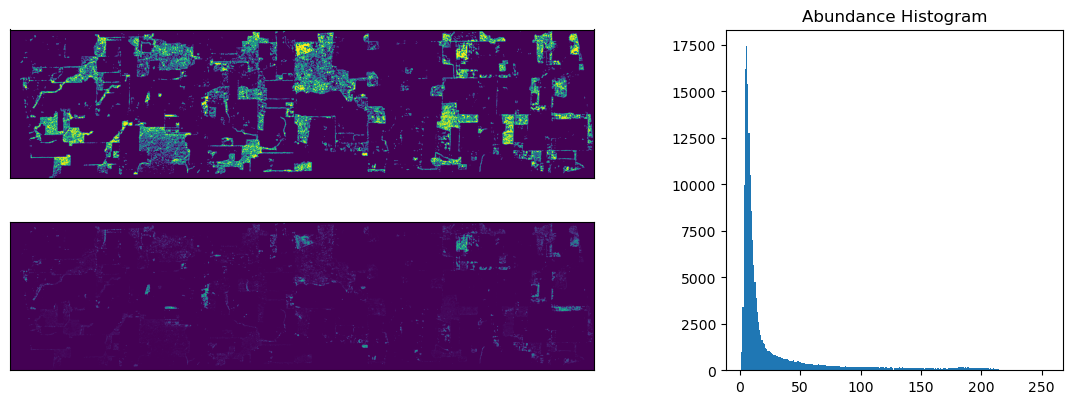

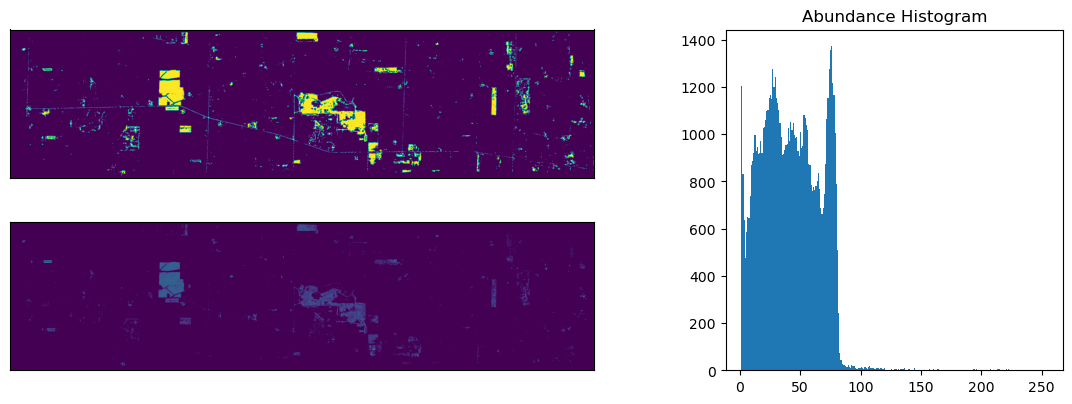

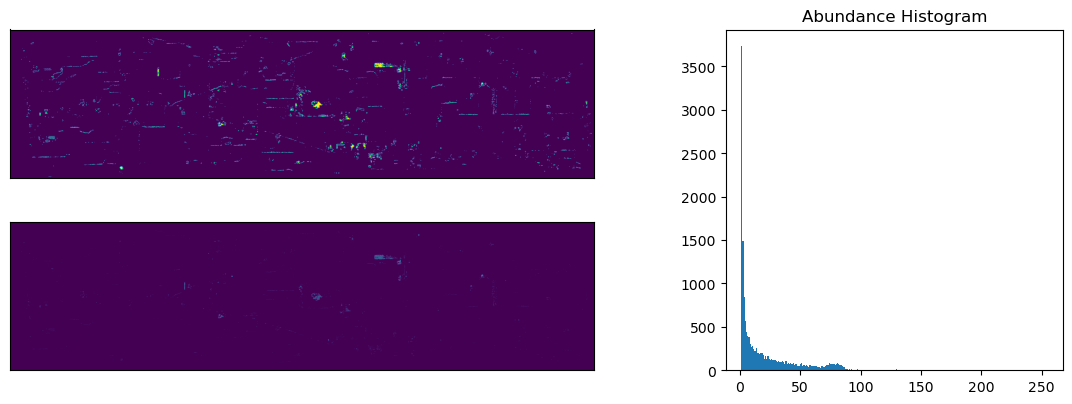

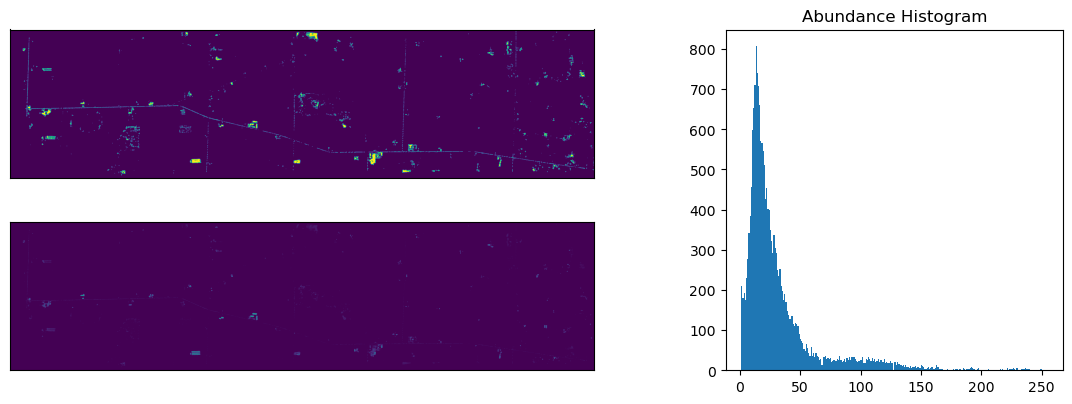

In [7]:
importlib.reload(ninjaGEO);
num = num - 1
ngeo = ninjaGEO.geo('veg_abundances.hdr')
'spectra2category_minerals_1'

In [63]:
im.metadata['band names']

['Kaol+Muscov_intimate CU93-5C',
 'Albite HS143.6  Plagioclase',
 'Dolomite.5+Na-Mont.5 AMX21',
 'Kaol.5+MuscCU91-250A AMX13',
 'Dolomite.5+Ca-Mont.5 AMX10',
 'Calc.25+Dolo.25+Ca-Mont AMX7',
 'Calc.25+Dolo.25+Na-Mon AMX18',
 'Vesuvianite HS446.2B Idocras',
 'Calcite.5+.Ca-Mont.5 AMX6',
 'Lepidolite HS167.3B',
 'Muscov+Jaros CU93-314 coatng',
 'Calcite.33+Na-Mont.67 AMX44',
 'Kaolinite KGa-1 (wxl)',
 'Montmorillonite SWy-1',
 'Pyrophyl.50+Ca-Mont.50 AMX16',
 'Pyrophyl.25+wxlKaol.75 AMX17',
 'Calcite.5+.Na-Mont.5 AMX43',
 'Muscovite-medlowAl CU91-250A',
 'Calcite.33+Ca-Mont.67 AMX19',
 'Calcite.7+Kaolin-wxl.3 AMX9',
 'Kaolinite KGa-2 (pxl)',
 'Cummingtonite HS294.6',
 'Serpentine HS8.3B',
 'Alun.33+Kaol.33+Musc.33 AMX2',
 'Calcite.5+Dolomite.5 AMX8',
 'Calcite GDS304 75-150um',
 'Kaol_Wxl+0.5Musc_Ruby AMX12',
 'Portlandite GDS525 Ca(OH)2',
 'Alunite.5+MuscCU91-250A AMX4',
 'Muscovite HS146.3B',
 'Anorthite HS349.4B Plagio',
 'Muscovite GDS113 Ruby',
 'Chrysotile ML99-12C Fine Fib',
 'Ser

In [ ]:
class pixe2Geocoordinates:
    def __init__(self, im):
        # get the ge location, if geo location data is present
        self.zone_number = im.metadata['map info'][7]
        self.zone_letter = im.metadata['map info'][8]
        # open the image file in GDAL
        im_gdal = gdal.Open(im.filename)
        # get the transformation parameters
        self.xoff, self.a, self.b, self.yoff, self.d, self.e = im_gdal.GetGeoTransform()
    def transform_single(self,coords):            
        x_utm = self.a * coords[1] + self.b * coords[0] + self.xoff
        y_utm = self.d * coords[1] + self.e * coords[0] + self.yoff
        lat, lon = utm.to_latlon(x_utm, y_utm, int(self.zone_number), self.zone_letter)
        retrun [lat, lon]
    def transform_shape(self,shapes):        
        coordinates = shapes['coordinates']  
        coordinates_out = [[]]
        for c in coordinates[0]:
            # get coords in UTM
            x_utm = self.a * c[0] + self.b * c[1] + self.xoff
            y_utm = self.d * c[0] + self.e * c[1] + self.yoff
            c = utm.to_latlon(x_utm, y_utm, int(self.zone_number), self.zone_letter)
            coordinates_out[0].append((c[1],c[0]))
        shapes['coordinates'] = coordinates_out
        return shapes

pix2Geo = pixe2Geocoordinates(im)

In [ ]:
import rasterio
from rasterio.transform import from_origin

arr = np.random.randint(5, size=(100,100)).astype('float')
transform = from_origin(4161038.942, 479975.540603, 0.5, 0.5)
new_dataset = rasterio.open('test3.tif', 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype),
                            crs='+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs',
                            transform=transform)
new_dataset.write(arr, 1)
new_dataset.close()

In [ ]:
# read the shapes as separate lists
abundance = []
geometry = []
material_class = []

for idx in range(1):
# get the name of the material for this band
    name = im.metadata['band names'][idx]
    print(name)
    abund = np.squeeze(coefIm[:,:,idx])
    ds_features = feats.shapes((abund>0.01).astype('int16'), mask=(abund>0.01))
    for shapedict, value in ds_features:
        abundance.append(value)
        geometry.append(shape(pix2Geo.transform_shape(shapedict)))
        material_class.append(name)

# build the gdf object over the lists
gdf = gpd.GeoDataFrame(
    {'abundance': abundance, 'geometry': geometry},
    crs="EPSG:4326"
)

# save the gdy to a shape file
gdf.to_file('minerals2')

gdf.plot();

In [ ]:
def raster2polygon(file_name, out_shp_fn, band_number=1, field_name="values"):
    """
    Convert a raster to polygon
    :param file_name: STR of target file name, including directory; must end on ".tif"
    :param out_shp_fn: STR of a shapefile name (with directory e.g., "C:/temp/poly.shp")
    :param band_number: INT of the raster band number to open (default: 1)
    :param field_name: STR of the field where raster pixel values will be stored (default: "values")
    :return: None
    """
    # ensure that the input raster contains integer values only and open the input raster
    file_name = float2int(file_name)
    raster, raster_band = open_raster(file_name, band_number=band_number)

    # create new shapefile with the create_shp function
    new_shp = create_shp(out_shp_fn, layer_name="raster_data", layer_type="polygon")
    dst_layer = new_shp.GetLayer()

    # create new field to define values
    new_field = ogr.FieldDefn(field_name, ogr.OFTInteger)
    dst_layer.CreateField(new_field)

    # Polygonize(band, hMaskBand[optional]=None, destination lyr, field ID, papszOptions=[], callback=None)
    gdal.Polygonize(raster_band, None, dst_layer, 0, [], callback=None)

    # create projection file
    srs = get_srs(raster)
    make_prj(out_shp_fn, int(srs.GetAuthorityCode(None)))
    print("Success: Wrote %s" % str(out_shp_fn))

In [ ]:



def create_shp(shp_file_dir, overwrite=True, *args, **kwargs):
    """
    :param shp_file_dir: STR of the (relative shapefile directory (ends on ".shp")
    :param overwrite: [optional] BOOL - if True, existing files are overwritten
    :kwarg layer_name: [optional] STR of the layer_name - if None: no layer will be created (max. 13 chars)
    :kwarg layer_type: [optional] STR ("point, "line", or "polygon") of the layer_name - if None: no layer will be created
    :output: returns an ogr shapefile layer
    """
    shp_driver = ogr.GetDriverByName("ESRI Shapefile")

    # check if output file exists if yes delete it
    if os.path.exists(shp_file_dir) and overwrite:
        shp_driver.DeleteDataSource(shp_file_dir)

    # create and return new shapefile object
    new_shp = shp_driver.CreateDataSource(shp_file_dir)

    # create layer if layer_name and layer_type are provided
    if kwargs.get("layer_name") and kwargs.get("layer_type"):
        # create dictionary of ogr.SHP-TYPES
        geometry_dict = {"point": ogr.wkbPoint,
                         "line": ogr.wkbMultiLineString,
                         "polygon": ogr.wkbMultiPolygon}
        # create layer
        try:
            new_shp.CreateLayer(str(kwargs.get("layer_name")),
                                geom_type=geometry_dict[str(kwargs.get("layer_type").lower())])
        except KeyError:
            print("Error: Invalid layer_type provided (must be 'point', 'line', or 'polygon').")
        except TypeError:
            print("Error: layer_name and layer_type must be string.")
        except AttributeError:
            print("Error: Cannot access layer - opened in other program?")
    return new_shp

In [ ]:
# saving a GeoTiff
arr = np.random.randint(5, size=(100,100)).astype(np.float)
transform = from_origin(472137, 5015782, 0.5, 0.5)
new_dataset = rasterio.open('test1.tif', 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype),
                            crs='+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs',
                            transform=transform)
new_dataset.write(arr, 1)
new_dataset.close()